# This notebook produces predictions from theory for consistency checks

In [1]:
import numpy as np
import pandas as pd
import healpy as hp
import matplotlib.pyplot as plt

import pyccl as ccl

from IPython.display import HTML
from IPython.display import display

Binning function from Sukhdeep

In [2]:
# Taken from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
tag = HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')
display(tag)

import itertools 

def bin_mat(r=[],mat=[],r_bins=[]):#works for cov and skewness
    bin_center=0.5*(r_bins[1:]+r_bins[:-1])
    n_bins=len(bin_center)
    ndim=len(mat.shape)
    mat_int=np.zeros([n_bins]*ndim,dtype='float64')
    norm_int=np.zeros([n_bins]*ndim,dtype='float64')
    bin_idx=np.digitize(r,r_bins)-1
    r2=np.sort(np.unique(np.append(r,r_bins))) #this takes care of problems around bin edges
    dr=np.gradient(r2)
    r2_idx=[i for i in np.arange(len(r2)) if r2[i] in r]
    dr=dr[r2_idx]
    r_dr=r*dr

    ls=['i','j','k','l']
    s1=ls[0]
    s2=ls[0]
    r_dr_m=r_dr
    for i in np.arange(ndim-1):
        s1=s2+','+ls[i+1]
        s2+=ls[i+1]
        r_dr_m=np.einsum(s1+'->'+s2,r_dr_m,r_dr)#works ok for 2-d case

    mat_r_dr=mat*r_dr_m
    for indxs in itertools.product(np.arange(min(bin_idx),n_bins),repeat=ndim):
        x={}#np.zeros_like(mat_r_dr,dtype='bool')
        norm_ijk=1
        mat_t=[]
        for nd in np.arange(ndim):
            slc = [slice(None)] * (ndim)
            #x[nd]=bin_idx==indxs[nd]
            slc[nd]=bin_idx==indxs[nd]
            if nd==0:
                mat_t=mat_r_dr[slc]
            else:
                mat_t=mat_t[slc]
            norm_ijk*=np.sum(r_dr[slc[nd]])
        if norm_ijk==0:
            continue
        mat_int[indxs]=np.sum(mat_t)/norm_ijk
        norm_int[indxs]=norm_ijk
    return bin_center,mat_int

## Section 1: Systematic Tests

### $C^{\kappa \kappa}_{l}$ from theory

In [3]:
#define cosmology Planck 2018 CMB Lensing Fiducial 1807.06210
cosmo = ccl.Cosmology(Omega_c = 0.268, Omega_b = 0.049, \
        h = 0.67, n_s = 0.964, sigma8 = 0.812, Omega_k=0) 

In [4]:
#define params
lmin = 100; lmax = 1500
ell = np.arange(0, lmax, 1)
fs = 18
alpha = 0.5

In [5]:
#calculate theoretical Cls
cmbl = ccl.CMBLensingTracer(cosmo, z_source=1090.)
cls_cmb_th = ccl.angular_cl(cosmo, cmbl, cmbl, ell)

### $C^{g g}_{l}$ from theory

Text(0.5, 1.0, 'dNdz from FDR')

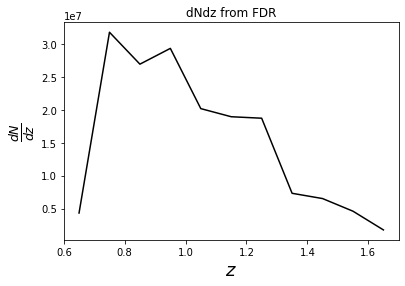

In [6]:
#read in dNdz
dNdzddeg2 = pd.read_csv("data/dNdz", sep=" ")

z = dNdzddeg2['z']
area = 14000
dNdz = dNdzddeg2['dNdzddeg2'] * area

fs = 18

plt.plot(z, dNdz, 'k-')
plt.xlabel(r"$z$", fontsize = fs)
plt.ylabel(r"$\frac{dN}{dz}$", fontsize = fs)
plt.title("dNdz from FDR")

In [7]:
#set constant bias
b = 1.25*np.ones(len(z))

#Create CCL tracer object for galaxy clustering
elgl = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z,dNdz), bias=(z,b))

In [8]:
#calculate theoretical Cls
cls_elg_th = ccl.angular_cl(cosmo, elgl, elgl, ell)

### $C^{\kappa g}_{l}$ from theory

In [9]:
#calculate theoretical Cls
cls_cross_th = ccl.angular_cl(cosmo, elgl, cmbl, ell)

All the three power spectra together:

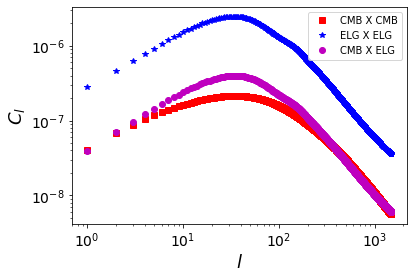

In [10]:
plt.xlabel('$l$',fontsize=fs)
plt.ylabel('$C_{l}$',fontsize=fs)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.xscale('log')


plt.plot(ell, cls_cmb_th, 'rs', label = "CMB X CMB")
plt.plot(ell, cls_elg_th, 'b*', label = "ELG X ELG")
plt.plot(ell, cls_cross_th, 'mo', label = "CMB X ELG")
plt.legend(loc = 'best')

Function to generate plots  from synthetic maps to compare against theory

In [11]:
def plot_powerspectra(cls, fields, ell_min = 0, ell_max = 1500, **kwargs):
    """Calculates power spectra using anafast and produces plots against theory
    cls: list of cls to be plotted
    fields: 'gg', 'kk' or 'kg'
    ell_min: minimum ell to be plotted
    ell_max: max ell to be plotted
    label: plot legend label"""
    
    fltr_ell = (ell > ell_min) & (ell < ell_max)
    
    if(fields == 'kk'):
        plt.loglog(ell[fltr_ell], cls_cmb_th[fltr_ell], c = "r", label = "CMB Theory")
        plt.ylabel(r"$C^{\kappa \kappa}_{l}$", fontsize = fs)
    elif(fields == 'gg'):
        plt.loglog(ell[fltr_ell], cls_elg_th[fltr_ell], c = "b", label = "ELG Theory")
        plt.ylabel(r"$C^{g g}_{l}$", fontsize = fs)
    elif((fields == 'kg') | (fields == 'gk')):
        plt.loglog(ell[fltr_ell], cls_cross_th[fltr_ell], c = "m", label = "CMB X ELG Theory")
        plt.ylabel(r"$C^{k g}_{l}$", fontsize = fs)
        
    plt.loglog(ell[fltr_ell], cls[fltr_ell], alpha = alpha, **kwargs)
    plt.xlabel(r"$l$", fontsize = fs)
    plt.legend(loc = 'best')

### Make synthetic maps

We are going to produce synthetic maps following Appendix of Giannantonio et al. 2008 (PhysRevD.77.123520).

Given two correlated maps $m_1$ and $m_2$, there are three power spectra $C^{11}_{l}$, $C^{12}_{l} = C^{21}_{l}$ and $C^{22}_{l}$. In this case, the coefficients of the spherical harmonics are given by:

\begin{align}
a^{1}_{lm} &= \xi_a \sqrt{C^{11}_{l}} \\
a^{2}_{lm} &= \xi_a \frac{C^{12}_{l}}{\sqrt{C^{11}_{l}}} + \xi_b \sqrt{C^{22}_{l} - \frac{\left(C^{12}_{l}\right)^2}{C^{11}_{l}}}
\end{align}

where $\xi$ is a random complex variable with mean $0$ and variance $1$, that denotes the random amplitude for a given mode. 

Now, Healpy *synfast* uses the *synalm* function to generate maps. The *synalm* function effectively does the following by taking $C_l$ as the input:

\begin{equation}
a_{lm} = \sqrt{C_l} \xi
\end{equation}

Thus, we can use this procedure to produce synthetic maps in the following way (assume $1 = \kappa and 2 = g$):

- Produce the first map, $m_1 = m_{\kappa}$ (CMB Lensing) using $C^{\kappa \kappa}_{l}$
- Produce an intermediary map, $m_p$ using $\frac{\left( C^{\kappa g}_{l} \right)^2}{C^{\kappa \kappa}_{l}}$ using the **same** seed as $m_1$.
- Produce another intermediary map with a **new** seed, $m_q$ using $C^{gg}_{l} - \frac{\left( C^{\kappa g}_{l} \right)^2}{C^{\kappa \kappa}_{l}}$
- Produce the second map, $m_2 = m_g$ (galaxy overdensity) using $m_g = m_p + m_q$

Limitations:
- This works for weakly correlated maps. For strongly correlated maps, the square root might give rise to errors. 
- This procedure only produces positive correlations due to the nature of synfast. 
    - If $C^{22}_{l}$ is negatively correlated, then the second map needs to be corrected by $m_2 *= -1$.
    - If $C^{22}_{l}$ is mixed, then produce intermediary maps $m_+$ and $m_-$ as $m_{+} = m_2$ and $m_{-} = -1 * m_2$ and afterwards $m_2 = m_{+} - m_{-}$.
    
    
---------
Also can do this by passing $C^{\kappa \kappa}_{l}$, $C^{\kappa g}_{l}$ and $C^{gg}_{l}$ to *synfast* and get $m_{\kappa}$ and $m_{g}$ out respectively.

First produce $m_{\kappa}$

/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/sphtfunc.py:400: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


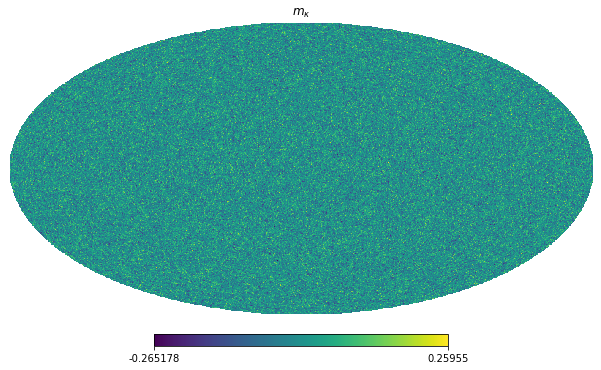

In [12]:
NSIDE = 1024
np.random.seed(1234)
m_k = hp.synfast(cls_cmb_th, nside=NSIDE * 2, pol=False)
hp.mollview(m_k, title = r"$m_{\kappa}$")

Now produce $m_g$

In [13]:
#add some small value to avoid floating-point error
cls_cmb_th[cls_cmb_th == 0] = 1e-15
np.random.seed(1234) #same seed as m_1
m_p = hp.synfast(cls_cross_th**2/cls_cmb_th, nside=NSIDE)
np.random.seed(4321) #new seed
m_q = hp.synfast(cls_elg_th - cls_cross_th**2/cls_cmb_th, nside=NSIDE)
m_g = m_p + m_q

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


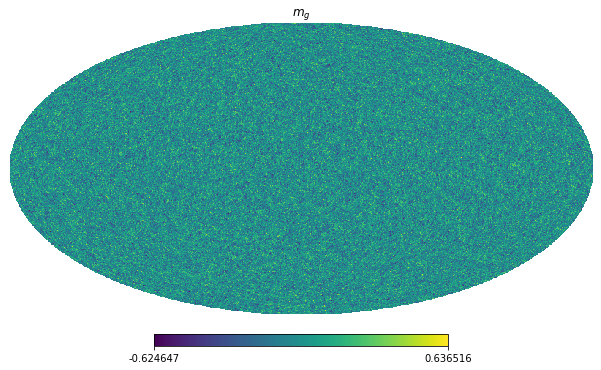

In [14]:
hp.mollview(m_g, title = r"$m_{g}$")

#### Test 1: Recover $C_l$ from synthetic maps

In [15]:
cl_cmb_obs = hp.anafast(m_k, lmax = lmax - 1)
cl_elg_obs = hp.anafast(m_g, lmax = lmax - 1)
cl_cross_obs = hp.anafast(hp.ud_grade(m_k, NSIDE), m_g, lmax = lmax - 1)

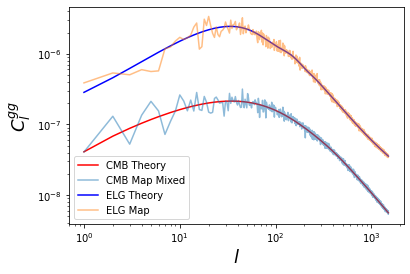

In [16]:
#auto
plot_powerspectra(cl_cmb_obs, 'kk', label = "CMB Map Mixed")
plot_powerspectra(cl_elg_obs, 'gg', label = "ELG Map")

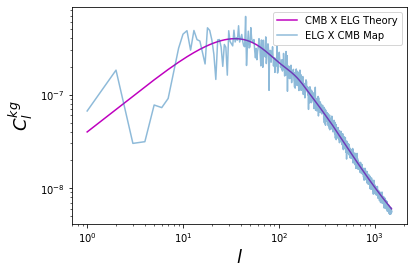

In [17]:
#cross
plot_powerspectra(cl_cross_obs, 'kg', label = "ELG X CMB Map")

***Conclusion 1: Recovered $C_l$ with Fourier noise.***

#### Test 2: Add mask and calculate $\tilde{C_l}$

Add Planck lensing mask to CMB signal

/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


NSIDE = 2048
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


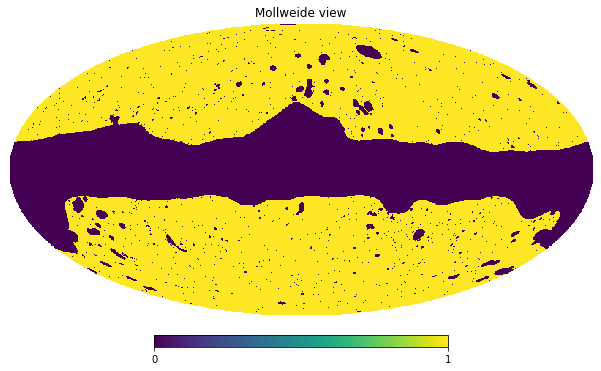

In [18]:
#Read Planck Lensing mask
lensingMask_planck = hp.fitsfunc.read_map("data/mask.fits")
hp.mollview(lensingMask_planck)

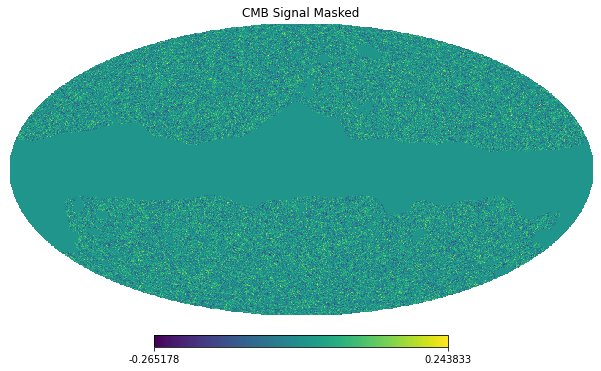

In [19]:
#Cover synthetic map with mask
m_k_masked = hp.ma(m_k, badval = 0)
m_k_masked.mask = np.logical_not(lensingMask_planck)
hp.mollview(m_k_masked, title = "CMB Signal Masked")

Add DR8 mask to ELG signal by rotating ELG catalogue from Eq. Coord. to Gal. Coord.

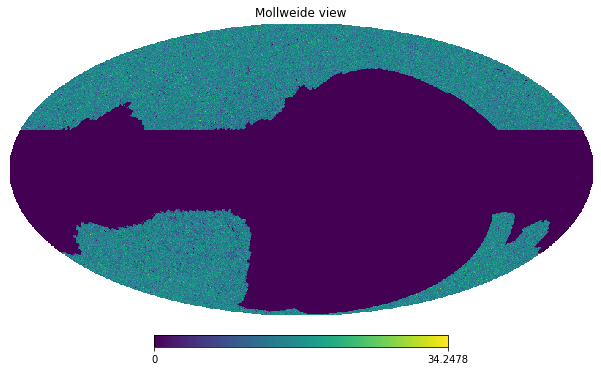

In [20]:
ranCat = np.load("data/elg_ran1024.npy") #use random ELG catalogue
#define rotator class from Eq. Coord. to Gal. Coord
r = hp.Rotator(coord=['C','G'])

ranCat_galactic = r.rotate_map_pixel(ranCat)
hp.mollview(ranCat_galactic)

In [21]:
#degrade DR8 map to remove small patches and then upgrade back to NSIDE to start making mask
ranCat_dgrade = hp.ud_grade(ranCat_galactic, 32)
ranCat_dgrade = hp.ud_grade(ranCat_dgrade, NSIDE)

#superimpose mask onto the mock map
m_g_masked = np.copy(m_g)
m_g_masked[ranCat_dgrade == 0] = 0

# generate mask
elg_mask = np.copy(m_g)
elg_mask[ranCat_dgrade == 0] = 0
elg_mask[ranCat_dgrade > 0] = 1

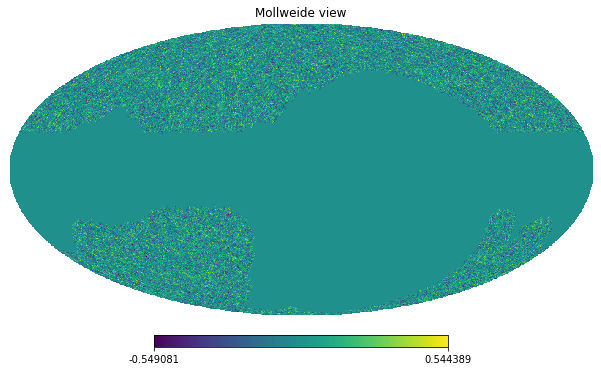

In [22]:
hp.mollview(m_g_masked)

In [23]:
#Calculate pseudo-Cls
cl_cmb_masked = hp.anafast(m_k_masked, lmax = lmax-1)
cl_elg_masked = hp.anafast(m_g_masked, lmax = lmax-1)
cl_cross_masked = hp.anafast(m_k_masked, m_g_masked, lmax = lmax-1)

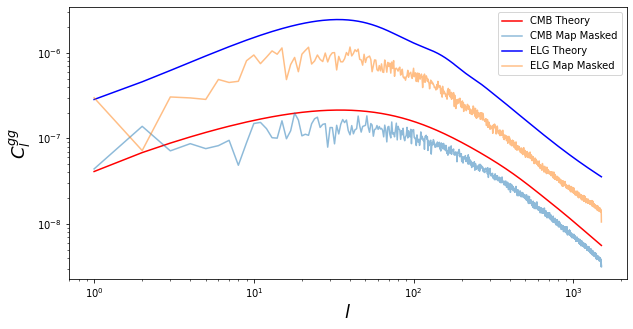

In [24]:
plt.figure(figsize=(10,5))
plot_powerspectra(cl_cmb_masked, 'kk', label = "CMB Map Masked")
plot_powerspectra(cl_elg_masked, 'gg', label = "ELG Map Masked")

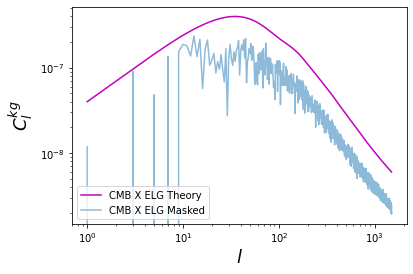

In [25]:
plot_powerspectra(cl_cross_masked, 'kg', label = "CMB X ELG Masked")

As expected, $\tilde{C_l}$ due to mask has lower signal expected. Need to correct for $f_{sky}.$

Correct for $f_{sky}$

In [26]:
#using boolean where Truth = observed pixel
fsky_lensing = lensingMask_planck.sum()/lensingMask_planck.size
fsky_elg = elg_mask.sum()/elg_mask.size

#Logical combine two masks to get cross-corr mask
cross_mask = np.logical_and(elg_mask, hp.ud_grade(lensingMask_planck, NSIDE))
fsky_cross = cross_mask.sum()/cross_mask.size

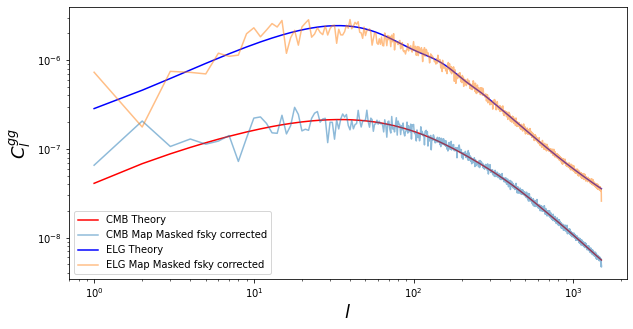

In [27]:
#auto
plt.figure(figsize=(10,5))
plot_powerspectra(cl_cmb_masked/fsky_lensing, 'kk', label = "CMB Map Masked fsky corrected")
plot_powerspectra(cl_elg_masked/fsky_elg, 'gg', label = "ELG Map Masked fsky corrected")

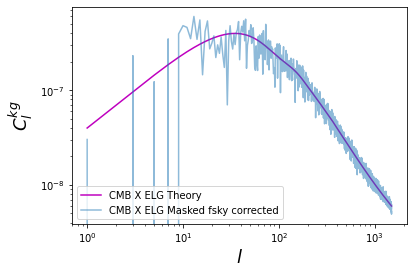

In [28]:
#cross
plot_powerspectra(cl_cross_masked/fsky_cross, 'kg', label = "CMB X ELG Masked fsky corrected")

Check difference between $C_{l}$ and $\tilde{C_l}$ where $\tilde{C_l}$ is corrected for $f_{sky}$

In [29]:
#plt.plot(ell[ell > 100], (1 - (cl_cmb_masked/fsky_lensing)/cls_cmb_th)[ell > 100], "rs", alpha = alpha, label = "CMB")
#plt.plot(ell[ell > 100], ((cl_elg_masked/fsky_elg)/cls_elg_th)[ell > 100], "b*", alpha = alpha, label = "ELG")
#plt.plot(ell[ell > 100], ((cl_cross_masked/fsky_cross)/cls_cross_th)[ell > 100], "mo", alpha = alpha, label = "Cross")
#plt.xlabel(r"$l$", fontsize = fs)
#plt.ylabel(r"$\frac{\tilde{C_l}}{C_l}$", fontsize = fs+10)
#plt.legend(loc = 'best')
#plt.axhline(0)
tmp = (1 - (cl_cmb_masked/fsky_lensing)/cls_cmb_th)[ell > 100]
print(f"CMB Mean = {np.round(tmp.mean(), 3)}, Std = {np.round(tmp.std(), 3)}")
tmp = (1 - (cl_elg_masked/fsky_elg)/cls_elg_th)[ell > 100]
print(f"ELG Mean = {np.round(tmp.mean(), 3)}, Std = {np.round(tmp.std(), 3)}")
tmp = (1 - (cl_cross_masked/fsky_cross)/cls_cross_th)[ell > 100]
print(f"Cross Mean = {np.round(tmp.mean(), 3)}, Std = {np.round(tmp.std(), 3)}")

CMB Mean = 0.0, Std = 0.046
ELG Mean = 0.001, Std = 0.048
Cross Mean = -0.002, Std = 0.107


/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


***Conclusion 2: Difference between $\tilde{C_l}$ and $C_l$ is very low after correcting for $f_{sky}$***

#### Test 3: Check whether changing badval to hp.UNSEEN affects the $C_l$ calculation

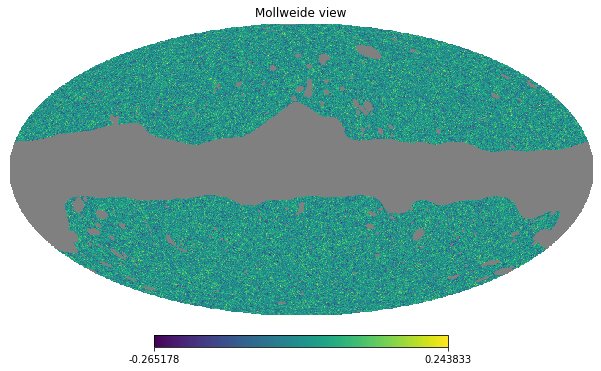

In [30]:
m_k_masked = np.copy(m_k)
m_k_masked[lensingMask_planck == 0] = hp.UNSEEN
hp.mollview(m_k_masked)

In [31]:
cl_cmb_masked2 = hp.anafast(m_k_masked, lmax = lmax-1)

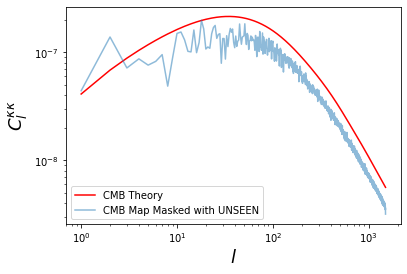

In [32]:
plot_powerspectra(cl_cmb_masked2, 'kk', label = "CMB Map Masked with UNSEEN")

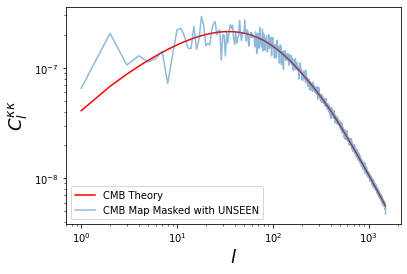

In [33]:
plot_powerspectra(cl_cmb_masked2/fsky_lensing, 'kk', label = "CMB Map Masked with UNSEEN")

***Conclusion 3: hp.UNSEEN does not affect the $\tilde{C_l}$ calculation.***

#### Test 4: Check the effect of smoothing on power spectrum recovery

We smooth the CMB Lensing map with FWHM = $5'$ (similar to Planck) and use the same random seed to generate a consistent map. 

/home/tanveer/anaconda3/lib/python3.7/site-packages/healpy/sphtfunc.py:400: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,


Sigma is 2.123305 arcmin (0.000618 rad) 
-> fwhm is 5.000000 arcmin


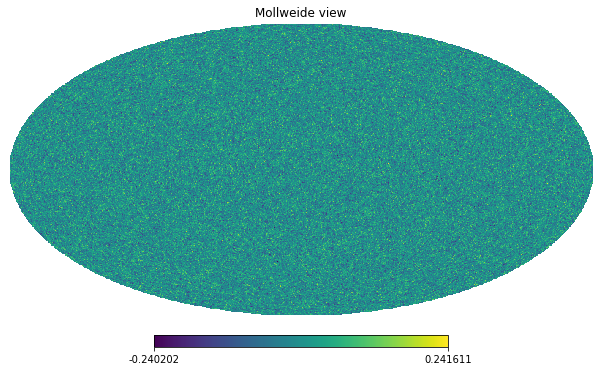

In [34]:
np.random.seed(1234)
FWHM = 5/60 #5 arcminutes
m_k_smoothed = hp.synfast(cls_cmb_th, nside=NSIDE * 2, pol=False, fwhm=np.deg2rad(FWHM))
hp.mollview(m_k_smoothed)

In [35]:
#Calculate pseudo-Cls
cl_cmb_smoothed = hp.anafast(m_k_smoothed, lmax = lmax-1)
cl_cross_smoothed = hp.anafast(hp.ud_grade(m_k_smoothed, NSIDE), m_g, lmax = lmax-1)

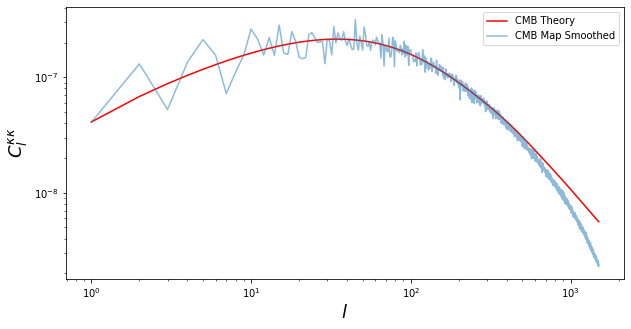

In [36]:
#auto
plt.figure(figsize=(10,5))
plot_powerspectra(cl_cmb_smoothed, 'kk', label = "CMB Map Smoothed")
#cross
#plot_powerspectra(cl_cross_smoothed, 'kg', label = "CMB X ELG Smoothed")

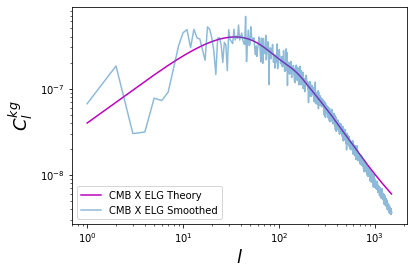

In [37]:
#cross
plot_powerspectra(cl_cross_smoothed, 'kg', label = "CMB X ELG Smoothed")

We notice that beyond $l$ of few hundreds, the observed $C_l$ diverges from theory. We plot the ratio of the smoothed $C_l$ with the theory $C_l$s.

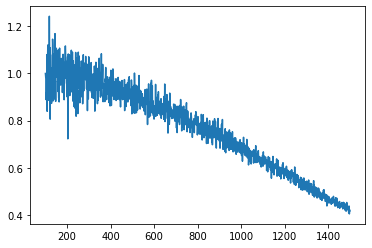

In [38]:
plt.plot(ell[ell>lmin], (cl_cmb_smoothed/cls_cmb_th)[ell>lmin])

We calculate the beam function to verify whether this divergence is due to the finite size of the beam.

Text(0, 0.5, '$\\frac{C_{l}^{smooth}}{C_{l}^{th}}$')

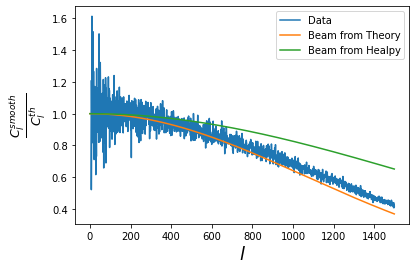

In [48]:
beam = lambda ell : np.exp(-(ell/lmax)**2)
beam_hp = hp.gauss_beam(fwhm=np.deg2rad(FWHM), lmax = lmax - 1)

lmin = 5
plt.plot(ell[ell>lmin], (cl_cmb_smoothed/cls_cmb_th)[ell>lmin], label = "Data")
plt.plot(ell, beam(ell), label = "Beam from Theory")
plt.plot(ell, beam_hp, label = 'Beam from Healpy')
plt.legend(loc = 'best')
plt.xlabel(r"$l$", fontsize = fs)
plt.ylabel(r"$\frac{C_{l}^{smooth}}{C_{l}^{th}}$", fontsize = fs)

Text(0, 0.5, '$C_l$ to beam ratio')

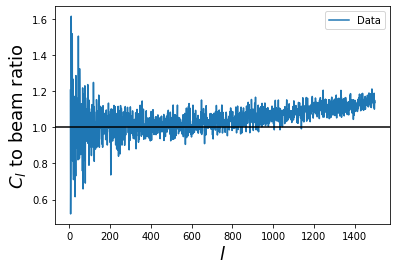

In [40]:
plt.plot(ell[ell>lmin], ((cl_cmb_smoothed/cls_cmb_th)/beam(ell))[ell>lmin], label = "Data")
plt.axhline(1, c = 'k')
plt.legend(loc = 'best')
plt.xlabel(r"$l$", fontsize = fs)
plt.ylabel(r"$C_l$ to beam ratio", fontsize = fs)

Text(0, 0.5, '$C_l$ to healpy beam ratio')

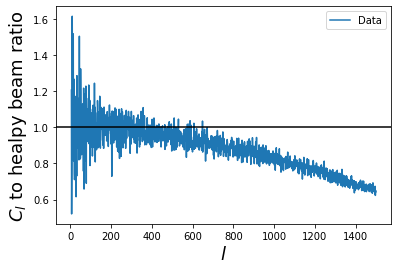

In [50]:
plt.plot(ell[ell>lmin], ((cl_cmb_smoothed/cls_cmb_th)/beam_hp)[ell>lmin], label = "Data")
plt.axhline(1, c = 'k')
plt.legend(loc = 'best')
plt.xlabel(r"$l$", fontsize = fs)
plt.ylabel(r"$C_l$ to healpy beam ratio", fontsize = fs)

***Conclusion 4: After correcting for the beam function, there is still some unaccounted signal above $l \sim 800$. On the other hand, after correcting with the Healpy, the recovered signal starts to get supressed around $l \sim 300$.***

#### Test 4: Check the effect of noise on power spectrum recovery

In [145]:
nlkk = np.genfromtxt("data/MV/nlkk.dat")
ell_planck = nlkk[:,0]
N_l = nlkk[:,1]
C_lplusN_l = nlkk[:,2]

Text(0.5, 0, '$l$')

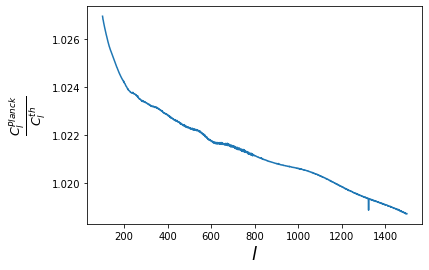

In [149]:
plt.plot(ell[ell > lmin], ((C_lplusN_l - N_l)[ell_planck < lmax]/cls_cmb_th)[ell > lmin])
plt.ylabel(r"$\frac{C^{Planck}_{l}}{C^{th}_{l}}$", fontsize = fs)
plt.xlabel(r'$l$', fontsize = fs)

We notice that there is a clear trend as a function of $l$. The denoised $C_l$ from Planck has a systematic offset from CCL theory by $2\%$. 

#### Metric 1: RCC

\begin{equation}
RCC_{l} = \frac{C^{\kappa g}_{l}}{\sqrt{C^{\kappa \kappa}_{l} C^{gg}_{l}}}
\end{equation}

If $\kappa$ is replaced by $m$, then $RCC = 1$ for systematic-free measurement as it is linear bias independent. Any noticeable deviation from $RCC = 1$ indicates systematics. Here, we calculate what $RCC_{l}$ should be from theory so we can compare observed $RCC$ against this. 

Text(0, 0.5, 'RCC')

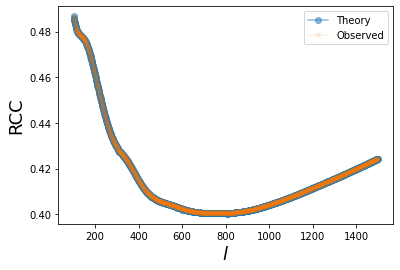

In [41]:
RCC_th = cls_cross_th/np.sqrt(cls_cmb_th * cls_elg_th)
RCC_obs = (cl_cross_masked/fsky_cross)/np.sqrt((cl_cmb_masked/fsky_lensing) * (cl_elg_masked/fsky_elg))
plt.plot(ell[ell > lmin], RCC_th[ell > lmin], label = "Theory", alpha = alpha, marker = "o")
plt.plot(ell[ell > lmin], RCC_th[ell > lmin], label = "Observed", alpha = .1, marker = "*")
plt.legend(loc = 'best')
plt.xlabel(r"$l$", fontsize = fs)
plt.ylabel("RCC", fontsize = fs)

***Observation 1: RCC metric is highly non-linear and not a constant of $1$ as a function of $l$.***

***Conclusion 4: RCC can be recovered almost exactly after correcting for $f_{sky}$.***

## Section 2: Running MCMC Inference 

In this section, we construct an analytic covariance matrix and a script to do cosmological inferences. 

#### Analytic Covariance Matrix

First we bin the data in bins of $100 l$:

In [42]:
#binned Cls by L = 100l
ELL = np.arange(0, lmax+1, 100)
%time ELL_centre, cl_cross_obs_binned = bin_mat(ell, cl_cross_obs, ELL)

CPU times: user 7.52 ms, sys: 0 ns, total: 7.52 ms
Wall time: 6.85 ms


/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


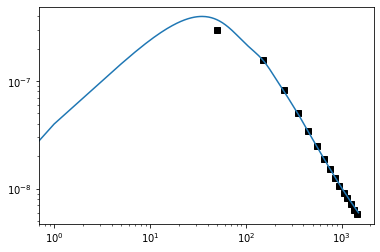

In [43]:
plt.loglog(ELL_centre, cl_cross_obs_binned, "ks")
plt.loglog(ell, cls_cross_th)

We will use analytic formulation of the covariance matrix for full-sky coverage assuming no noise:

\begin{equation}
\sigma^{2}_{C^{\kappa g}_{l}} = \frac{1}{\left( 2l + 1 \right) f_{sky}} \left[ \left( C^{\kappa g}_{l} \right)^2  + C^{\kappa \kappa}_{l} C^{gg}_{l} \right]
\end{equation}

In [98]:
covCls = 1/fsky_cross * np.diag(1/(2 * ell + 1) * ((cls_cross_th)**2 + cls_cmb_th * cls_elg_th))
covCls_binned = bin_mat(ell, covCls, ELL)[1]

ivarCls = np.linalg.inv(covCls)
ivarCls_binned = np.linalg.inv(covCls_binned) 

/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/tanveer/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


We will do inference on two parameters, $\theta$ = [$\Omega_c, \sigma_8$].

In [99]:
import emcee
import corner

In [111]:
#define loglikelihood
#def loglike(theta, data = cl_cross_obs, ivar = ivarCls):
def loglike(theta):
    cosmo = ccl.Cosmology(Omega_c = theta[0], Omega_b = 0.049,
         h = 0.67, n_s = 0.964, sigma8 = theta[1], Omega_k=0,
        transfer_function='bbks')
        
    cmbl = ccl.CMBLensingTracer(cosmo, z_source=1090.)
    elgl = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z,dNdz), bias=(z,b))
    model = ccl.angular_cl(cosmo, cmbl, elgl, ell)
    
    #_, model_binned = bin_mat(ell, model, ELL)
    diff = cl_cross_obs - model
    #diff = data - model_binned
    
    return -0.5 * (diff).T @ ivarCls @ diff

In [101]:
#utils functions 
def mcmc(loglikelihood, init_pos, nsamples, thread):
    """Returns emcee sampler based on log likelihood,
    initial position and number of walkers."""
    
    nwalkers = init_pos.shape[0]
    ndim = init_pos.shape[1]
    #initiate sampler and run
    sampler = emcee.EnsembleSampler(nwalkers, ndim, loglikelihood, threads=thread)
    sampler.run_mcmc(p0, nsamples, progress=True);
    
    return sampler

def trace_autocorr(sampler, labels):
    """Returns traceplots and autocorrelation time
    of parameters based on emcee chain output.
    
    Parameters
    ----------
    samples : sampler.get_chain() output from emcee
    labels : names of parameters 
    """
    
    samples = sampler.get_chain()
    ndim = samples.shape[2]
    fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
    
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i], fontsize = 15)
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number");
    
    #check auto-correlation time
    tau = sampler.get_autocorr_time()
    print(tau)
    
def burn_thin(sampler,  burn_in, thinning):
    """Returns flattened chains after burn-in and thinning."""
    
    flat_samples = sampler.get_chain(discard=burn_in, thin=thinning,
                    flat=True)
    return flat_samples

def cornerplot(flat_samples, **kwargs):
    figure = corner.corner(flat_samples, **kwargs)

In [102]:
#setup walkers
nwalkers = 10; ndim = 2
np.random.seed(24)
p0 = np.random.multivariate_normal(mean = np.array([0.268, 0.812]), 
                                cov = np.array([[0.00001, 0], [0, 0.00001]]), 
                              size = nwalkers)

In [108]:
def mcmc_parallel(loglikelihood, init_pos, nsamples):

    nwalkers = init_pos.shape[0]
    ndim = init_pos.shape[1]
    
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(
            nwalkers, ndim, loglikelihood, pool=pool)
        #start = time.time()
        sampler.run_mcmc(p0, nsamples, progress=True);
        #end = time.time()
        #multi_data_time = end - start
        print("Multiprocessing took {0:.1f} seconds".format(multi_data_time))
        #print(
        #    "{0:.1f} times faster(?) than serial".format(serial_data_time / multi_data_time)
        #)

In [113]:
%time loglike(p0[0]+.2)

CPU times: user 480 ms, sys: 16.4 ms, total: 496 ms
Wall time: 212 ms


-143841.22273011718

In [106]:
#run sampler
%time sampler = mcmc(loglikelihood=loglike, init_pos=p0, nsamples=5, thread = 7)

100%|██████████| 5/5 [00:10<00:00,  2.19s/it]

CPU times: user 38.2 s, sys: 22 s, total: 1min
Wall time: 13.2 s


AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [24.69254467 22.74713592]

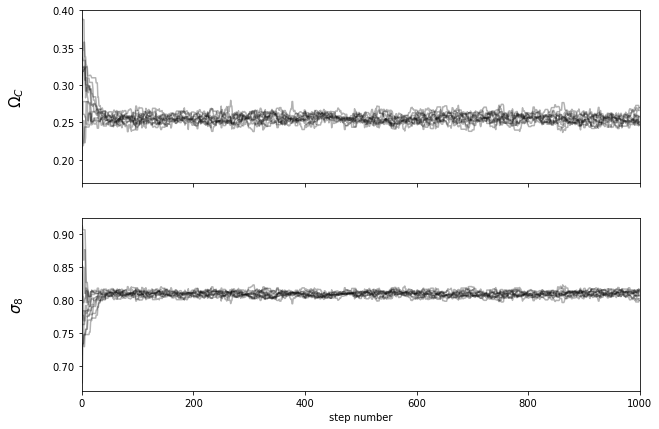

In [46]:
trace_autocorr(sampler, [r"$\Omega_C$", "$\sigma_8$"])

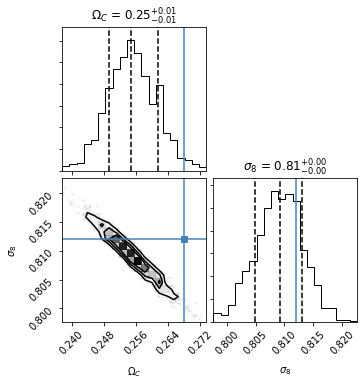

In [50]:
#burn-in and thinning
flat_samples = burn_thin(sampler, 50, 10)

#cornerplot
cornerplot(flat_samples, labels = [r"$\Omega_C$", "$\sigma_8$"],
        quantiles=np.array([.16, .5, .84]), truths=np.array([0.268, 0.812]),
        show_titles=True, title_kwargs={"fontsize": 12})

Observations:
- The sampler takes an unusually long amount of time to run. Each iteration takes roughly $7.5$ seconds to compute which makes this procedure very expensive, even for two parameters. 
- The autocorrelation time diagnostic suggests that 1000 points are not enough and we need to run the chain longer. However, with each iteration taking $7.5$ seconds, this becomes a very expensive procedure. 
- The final result is nowhere near the truth. Even with $0$ noise and full-sky signal, the inferred $\Omega_{C}$ is really off, and the $\sigma_{8}$ measurement is somewhat off. 

In [114]:
from multiprocessing import Pool

#run sampler
sampler = mcmc_parallel(loglikelihood=loglike, init_pos=p0, nsamples=5)

KeyboardInterrupt: 